### Import necessary packages

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, GlobalAveragePooling2D, MaxPooling2D, Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

### Load raw data

Use CEDAR benchmark as dataset.

In [2]:
DATA_DIR = './signatures/'
groups_list = next(os.walk(DATA_DIR))[1]
groups_list.sort()

CEDAR has 2 folders: full_forg and full_org. Each folder contains 1320 signatures (24 signatures for each of 55 writers).

In [3]:
IMG_SHAPE = (128, 128, 1)
H, W, D = IMG_SHAPE
N_WRITERS = 55
N_SIGNATURES_PER_WRITER = 24

In [4]:
writers = []

# Loop through each folder
for group in groups_list:
    image_names = os.listdir(DATA_DIR + group)
    image_names.remove('Thumbs.db')
    
    for i in range(N_WRITERS):
        # Get a batch of size 24, which means a batch that corresponds to a writer's signatures
        writer_signatures = []
        start = N_SIGNATURES_PER_WRITER * i
        end = N_SIGNATURES_PER_WRITER * (i + 1)
        images_per_writer = image_names[start:end]
    
        # For each image in batch
        for image_per_writer in images_per_writer:
            img_path = DATA_DIR + group + '/' + image_per_writer
            # Load image as grayscale with the desirable size
            img = load_img(img_path, color_mode="grayscale", target_size=(H, W))
            # Normalize the image
            img = np.array(img) / 255.
            writer_signatures.append(img)
        
        # Forgery (or genuine) signatures of a writer
        writers.append(writer_signatures)

# Forgery group will be the first 55 elements in writer list, and genuine group is the rest of that one
forg_group = np.array(writers[:N_WRITERS])
orig_group = np.array(writers[N_WRITERS:])

Take a look at each group shape.

In [5]:
print(f'{forg_group.shape}\n{orig_group.shape}')

(55, 24, 128, 128)
(55, 24, 128, 128)


Visualize the writer's signatures (both forgery and genuine).

In [6]:
def visualize_data(orig, forg):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 5))
    w = np.random.randint(orig.shape[0])
    s = np.random.randint(orig.shape[1])
    ax1.imshow(orig[w][s], cmap='gray')
    ax2.imshow(forg[w][s], cmap='gray')
    ax1.set_title('Genuine signature')
    ax1.axis('off')
    ax2.set_title('Forgery signature')
    ax2.axis('off')

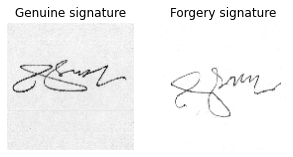

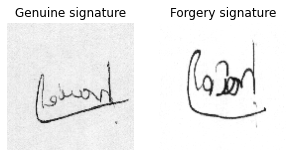

In [7]:
for i in range(2):
    visualize_data(orig_group, forg_group)

### Prepare positive and negative pairs

In [8]:
def make_pairs(orig, forg):
    pair_images = []
    pair_labels = []
    
    for w in range(N_WRITERS):
        
        # ==================== Positive pairs: Genuine-Genuine pairs of a writer ===================== #
        for i in range(N_SIGNATURES_PER_WRITER - 1):
            for j in range(i + 1, N_SIGNATURES_PER_WRITER):
                pair_images.append([orig[w][i], orig[w][j]])
                pair_labels.append([1])
        
        # ==== Negative pairs: NOT take all negative pairs to avoid making the dataset unbalanced ==== #
        
        # Genuine-Forgery pairs of a writer
        for i in range(N_SIGNATURES_PER_WRITER - 5 - 1):
            for j in range(i + 1, N_SIGNATURES_PER_WRITER - 5):
                pair_images.append([orig[w][i], forg[w][j]])
                pair_labels.append([0])
                
        # Genuine signature of a writer and other writer's signature
        for nw in range(w + 1, N_WRITERS):
            for i in range(N_SIGNATURES_PER_WRITER - 21 - 1):
                for j in range(i + 1, N_SIGNATURES_PER_WRITER - 21):           
                    pair_images.append([orig[w][i], orig[nw][j]])
                    pair_labels.append([0])
                    pair_images.append([orig[w][i], forg[nw][j]])
                    pair_labels.append([0])
        
    return np.array(pair_images, dtype=np.float32), np.array(pair_labels, dtype=np.float32)

In [9]:
print("[INFO] preparing positive and negative pairs...")
pair_images, pair_labels = make_pairs(orig_group, forg_group)

[INFO] preparing positive and negative pairs...


In [10]:
print(f'{pair_images.shape}\n{pair_labels.shape}') # 15180 + 9405 + 8910

(33495, 2, 128, 128)
(33495, 1)


In [11]:
# Shuffle image pairs and their corresponding labels to break the correlation between samples
X_shuffled, y_shuffled = shuffle(pair_images, pair_labels, random_state=2)

In [12]:
# The percentages of train, validation, and test are 80%, 10%, and 10% respectively
X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.2, random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2)

### Helper functions

In [13]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))
    
def contrastive_loss(y_true, y_pred, margin=1):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)

def plot_training(H, plot_path):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(H.history['loss'], label='train_loss')
    plt.plot(H.history['val_loss'], label='val_loss')
    plt.plot(H.history['acc'], label='train_acc')
    plt.plot(H.history['val_acc'], label='val_acc')
    plt.title('Training Loss and Accuracy')
    plt.xlabel('Epoch #')
    plt.ylabel('Loss/Accuracy')
    plt.legend(loc='lower left')
    plt.savefig(plot_path)

### Build the Siamese Network

In [14]:
def build_siamese_model(input_shape, embedding_dim=48):
    # Specify the inputs for the feature extractor network
    inputs = Input(input_shape)

    # Define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    # Second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # Prepare the final outputs
    pooled_output = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_dim)(pooled_output)

    # Build the model
    model = Model(inputs, outputs)

    # Return the model to the calling function
    return model

In [15]:
# Configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
feature_extractor = build_siamese_model(IMG_SHAPE)
print(feature_extractor.summary())
featsA = feature_extractor(imgA)
featsB = feature_extractor(imgB)

[INFO] building siamese network...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)       

In [16]:
# Construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
output   = Dense(1, activation="sigmoid")(distance)
model    = Model(inputs=[imgA, imgB], outputs=output)

In [17]:
# Compile the model
print("[INFO] compiling model...")
model.compile(loss=contrastive_loss, optimizer='RMSprop', metrics=['acc'])

[INFO] compiling model...


### Train the Siamese Network

In [18]:
N_TRAIN = len(X_train)
N_VAL   = len(X_val)
BATCH_SIZE = 32
EPOCHS = 5

# Train the model
print("[INFO] training model...")
history = model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train, 
    batch_size=BATCH_SIZE, 
    steps_per_epoch=np.ceil(N_TRAIN/BATCH_SIZE), 
    epochs=EPOCHS, 
    validation_data=([X_val[:, 0], X_val[:, 1]], y_val),
    validation_steps=np.ceil(N_VAL/BATCH_SIZE))

[INFO] training model...
Epoch 1/5
838/838 [==============================] - 36s 38ms/step - loss: 0.1578 - acc: 0.7287 - val_loss: 0.1356 - val_acc: 0.8731
Epoch 2/5
838/838 [==============================] - 32s 38ms/step - loss: 0.1117 - acc: 0.8836 - val_loss: 0.0971 - val_acc: 0.9068
Epoch 3/5
838/838 [==============================] - 32s 38ms/step - loss: 0.0835 - acc: 0.9175 - val_loss: 0.0751 - val_acc: 0.9203
Epoch 4/5
838/838 [==============================] - 32s 38ms/step - loss: 0.0687 - acc: 0.9271 - val_loss: 0.0879 - val_acc: 0.8982
Epoch 5/5
838/838 [==============================] - 32s 38ms/step - loss: 0.0616 - acc: 0.9308 - val_loss: 0.0661 - val_acc: 0.9149


In [19]:
OUTPUT_DIR = './output'
MODEL_PATH = OUTPUT_DIR + '/siamese_model'
PLOT_PATH  = OUTPUT_DIR + '/plot.png'

In [20]:
print("[INFO] saving siamese model...")
model.save(MODEL_PATH)

[INFO] saving siamese model...
INFO:tensorflow:Assets written to: ./output/siamese_model\assets


[INFO] plotting training history...


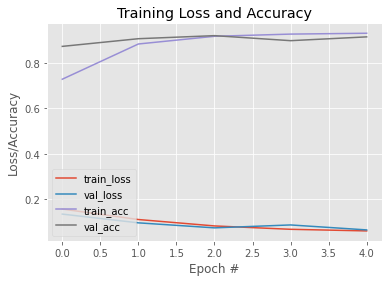

In [21]:
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)

### Evaluate model

In [22]:
def visualize_predictions(pairs, labels, to_show=6, num_col=3, predictions=None):
    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axes = plt.subplots(num_row, num_col, figsize=(6, 6))
    for i in range(to_show):
        k = np.random.randint(len(pairs))
        ax = axes[i % num_col] if num_row == 1 else axes[i // num_col, i % num_col]
        ax.imshow(tf.concat([pairs[k][0], pairs[k][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        ax.set_title("True: {} | Pred: {:.5f}".format(labels[k][0], predictions[k][0]))
    
    plt.tight_layout(rect=(0, 0, 2, 2), w_pad=5.0)
    plt.show()

In [23]:
results = model.evaluate([X_test[:, 0], X_test[:, 1]], y_test)
print("test_loss, test_acc:", results)

105/105 [==============================] - 2s 14ms/step - loss: 0.0629 - acc: 0.9212
test_loss, test_acc: [0.06292253732681274, 0.9211940169334412]


Predict the label of each sample in test set, and visualize the results.

In [24]:
preds = model.predict([X_test[:, 0], X_test[:, 1]])

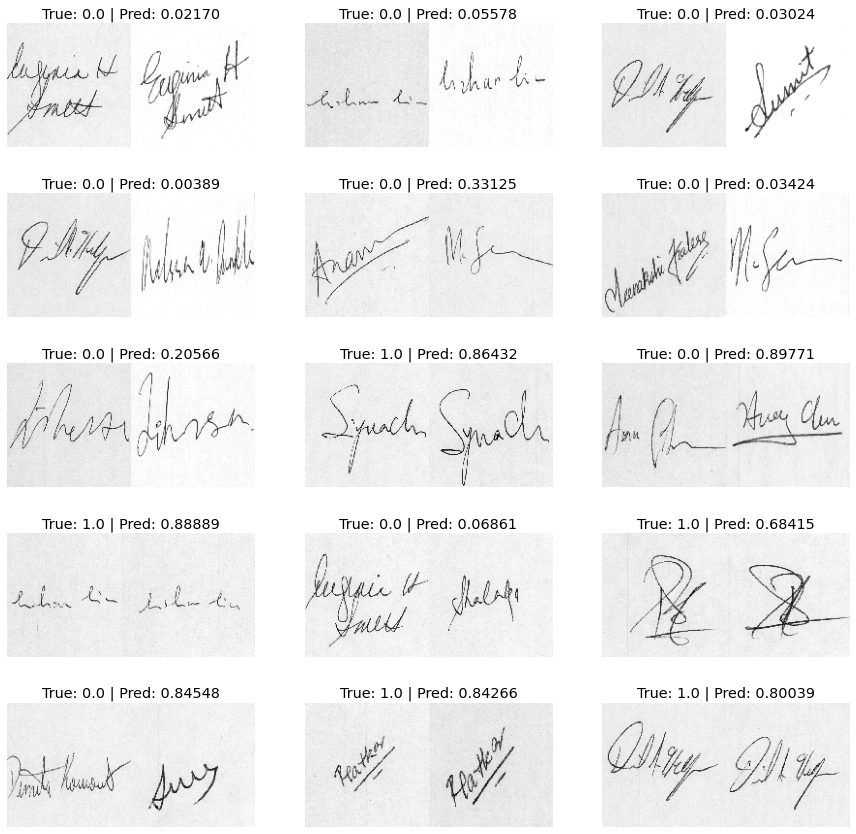

In [31]:
visualize_predictions(X_test, y_test, to_show=15, predictions=preds)